In [1]:
import os

In [2]:
import nltk
from nltk.corpus import stopwords
import pandas as pd


nltk.download('stopwords')
stop = stopwords.words('english')
df_text = pd.read_csv('rnews_apple.txt', sep=': \"', header=None, names=['date', 'text'], dtype='str', engine='python')
df_text['text_without_stopwords'] = df_text['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(df_text['text'][:3])
print(df_text['text_without_stopwords'][:3])


# reviews_len = [len(row['text'].split(" ")) for idx, row in df_text.iterrows()]
# pd.Series(reviews_len).hist()
# plt.savefig('hist.png')
# pd.Series(reviews_len).describe()

0                  Armed robbers hit Paris Apple store
1    UPDATE 1-Judge rejects part of Apple App Store...
2    US STOCKS-Data helps pace Wall St higher, but ...
Name: text, dtype: object
0                  Armed robbers hit Paris Apple store
1    UPDATE 1-Judge rejects part Apple App Store su...
2    US STOCKS-Data helps pace Wall St higher, Appl...
Name: text_without_stopwords, dtype: object


[nltk_data] Downloading package stopwords to /home/bowman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import pandas as pd

df = pd.read_csv('all_stocks_5yr.csv')
df = df.loc[(df['Name'] == "AAPL")]
df = df.drop('volume', 1)
df = df.drop('high', 1)
df = df.drop('low', 1)
df = df.drop('Name', 1)
print('df.shape',df.shape)
print(df[:3])
df = df.sort_values('date').reset_index(drop=True)
df = df.dropna()

# rmls = [x for x in range(500,600)] + [y for y in range(1100,1200)]
# rmls = [x for x in range(500)] + [y for y in range(600,1100)] + [z for z in range(1200,1259)]

# df = df.drop(df.index[rmls])
print('df.shape',df.shape)

df.shape (1259, 3)
            date     open    close
1259  2013-02-08  67.7142  67.8542
1260  2013-02-11  68.0714  68.5614
1261  2013-02-12  68.5014  66.8428
df.shape (1259, 3)


In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import datetime
from tqdm import tqdm
import copy
import pickle

class MainRNN():
    def __init__(self):
        self.data_time_range=10
        self.seq_size=self.data_time_range
        self.hidden_layer=32
        self.output_feature_size=1
        self.epochs=1
        self.batch_size=64
        self.first = True
        
    def x_y_to_seq(self, X):
        newX = []
        newY = []
        for i in range(int(len(X) - self.seq_size)):
            newX.append(X[i : (i + self.seq_size)])
            newY.append([X[(i + self.seq_size)][1]])

        return newX, newY

    def get_formated_data(self):
                
        count_vectorizer = CountVectorizer(decode_error='ignore',binary=False)
        X_text = count_vectorizer.fit_transform(df_text['text_without_stopwords'])
        X_text = X_text.toarray()
        
        
        
        print(X_text.shape)

        X = []
        Y = []
        for index, row in tqdm(df.iterrows()):
            row_data_array = row.values[1:]
            row_day = row['date'].split('-')[2]
            row_mon = row['date'].split('-')[1]
            row_year = row['date'].split('-')[0]
            text_index = df_text[(df_text['date'] == row_mon + row_day + row_year)].index.values.astype(int)
            if len(text_index) > 0:
                text_index = text_index[0]

                if (text_index) >= 0:
                    row_data_array = np.append(row_data_array, np.array(X_text[text_index], dtype=np.int))
                else:
                    _, shape_for_use = np.array(X_text).shape
                    row_data_array = np.append(row_data_array, np.zeros(shape_for_use, dtype=np.int))
            else:
                _, shape_for_use = np.array(X_text).shape
                row_data_array = np.append(row_data_array, np.zeros(shape_for_use, dtype=np.int))
                
            X.append(row_data_array)
        
        X, Y = self.x_y_to_seq(X)
        print(X[1], Y[1])
        
        return np.array(X), np.array(Y)


    def process_train(self, X, Y):

        # get shape X (N, T, D)
        X_sample_size, X_seq_size, X_features_size = X.shape
        print('X_features_size', X_features_size)

        # get shape Y (K)
        Y_sample_size = Y.shape

        # init weight and bias
        weights = tf.Variable(tf.random_normal([self.hidden_layer, self.output_feature_size]))
        biases = tf.Variable(tf.random_normal([self.output_feature_size]))

        # placeholder for graph input
        tfX = tf.placeholder(tf.float32, shape=[None, X_seq_size, X_features_size], name='inputX')
        tfY = tf.placeholder(tf.float32, shape=[None, self.output_feature_size], name='inputY')

        # transposeX
        tfX = tf.transpose(tfX, [1, 0, 2])

        # define lstm cell
        lstmCell = tf.nn.rnn_cell.BasicLSTMCell(self.hidden_layer)

        # create RNN unit
        outputs, states = tf.nn.dynamic_rnn(cell=lstmCell, inputs=tfX, dtype=tf.float32)

        # get rnn output
        outputs = tf.stack(outputs)

        # transpose output back
        outputs = tf.transpose(outputs, [1, 0, 2])
        # outputs = tf.reshape(outputs, [outputs.get_shape()[-1], self.hidden_layer])

        # Hack to build the indexing and retrieve the right output.
        # Start indices for each sample
        index = tf.range(0, tf.shape(outputs)[0]) * X_seq_size + (X_seq_size - 1)
        # Indexing
        outputs = tf.gather(tf.reshape(outputs, [-1, self.hidden_layer]), index)

        # prediction
        prediction = tf.matmul(outputs, weights) + biases
        label = tfY

        # cost function
        loss = tf.reduce_mean(tf.square(prediction - tfY))

        # optimizer
        optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(loss)

        # cost[] and accuracies[]
        epoch_pred=[]
        epoch_lab=[]
        iterl=[]
        

        # global init
        init = tf.global_variables_initializer()

        # start training
        with tf.Session() as sess:
            saver = tf.train.Saver()
            sess.run(init)

            for epoch in range(self.epochs):
                costs=[]
                print('===== EPOCH ======: ', epoch)
                if not self.first:
                    saver.restore(sess,"./trained_model")
                    self.first=False
                else:
                    if os.path.exists('./trained_model'): 
                        saver.restore(sess,"./trained_model")
                        self.first=False

#                 X, Y = shuffle(X, Y)
            
                c=0
                for batch in tqdm(range(X_sample_size - self.batch_size)):
                    batchX = X[batch:batch+self.batch_size]
                    batchY = Y[batch:batch+self.batch_size]

                    _, cost_out, prediction_out = sess.run([optimizer, loss, prediction], feed_dict={tfX: batchX.reshape(X_seq_size, self.batch_size, X_features_size), tfY: batchY.reshape(self.batch_size, self.output_feature_size)})
                    costs.append(cost_out)
                    if epoch == self.epochs-1:
                        
                        epoch_pred.append(prediction_out[1])
                        epoch_lab.append(Y[batch+1])
                        iterl.append(c)
                        c+=1

                meanse = sum(costs) / float(len(costs))
                
                print('meanse: ', meanse)
                
                saver.save(sess, "./trained_model")

            np.random.seed(0)
#             plt.plot(epochsl, epochs_costs, 'g^')
            plt.plot(iterl, epoch_pred, 'r--', iterl, epoch_lab, 'b--')
            plt.savefig('costs.png')


    def run_prediction(self):
        print('start time:', datetime.datetime.now())
        X, Y = self.get_formated_data()
        self.process_train(X, Y)
        print('end time:', datetime.datetime.now())

59it [00:00, 589.24it/s]

start time: 2019-05-16 21:55:01.469824
(1160, 2712)


1259it [00:01, 862.58it/s]


[array([68.0714, 68.5614, 0, ..., 0, 0, 0], dtype=object), array([68.5014, 66.8428, 0, ..., 0, 0, 0], dtype=object), array([66.7442, 66.7156, 0, ..., 0, 0, 0], dtype=object), array([66.3599, 66.6556, 0, ..., 0, 0, 0], dtype=object), array([66.9785, 65.7371, 0, ..., 0, 0, 0], dtype=object), array([65.8714, 65.7128, 0, ..., 0, 0, 0], dtype=object), array([65.3842, 64.1214, 0, ..., 0, 0, 0], dtype=object), array([63.7142, 63.7228, 0, ..., 0, 0, 0], dtype=object), array([64.1785, 64.4014, 0, ..., 0, 0, 0], dtype=object), array([64.8356, 63.2571, 0, ..., 0, 0, 0], dtype=object)] [64.1385]
X_features_size

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
  0%|          | 1/1185 [00:00<03:41,  5.36it/s]

 2714
===== EPOCH ======:  0


100%|██████████| 1185/1185 [02:15<00:00,  8.50it/s]


meanse:  4745.13268383686
end time: 2019-05-16 21:57:19.786602


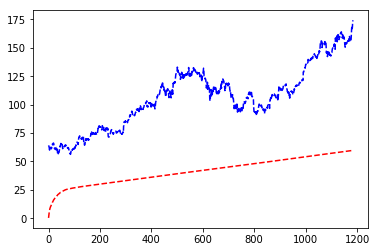

In [5]:
MainRNN().run_prediction()

In [6]:
MainRNN().run_prediction()

88it [00:00, 872.07it/s]

start time: 2019-05-16 21:58:37.714033
(1160, 2712)


1259it [00:01, 882.41it/s]


[array([68.0714, 68.5614, 0, ..., 0, 0, 0], dtype=object), array([68.5014, 66.8428, 0, ..., 0, 0, 0], dtype=object), array([66.7442, 66.7156, 0, ..., 0, 0, 0], dtype=object), array([66.3599, 66.6556, 0, ..., 0, 0, 0], dtype=object), array([66.9785, 65.7371, 0, ..., 0, 0, 0], dtype=object), array([65.8714, 65.7128, 0, ..., 0, 0, 0], dtype=object), array([65.3842, 64.1214, 0, ..., 0, 0, 0], dtype=object), array([63.7142, 63.7228, 0, ..., 0, 0, 0], dtype=object), array([64.1785, 64.4014, 0, ..., 0, 0, 0], dtype=object), array([64.8356, 63.2571, 0, ..., 0, 0, 0], dtype=object)] [64.1385]
X_features_size 2714


ValueError: Variable rnn/basic_lstm_cell/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-4-3eac3a8dcff2>", line 94, in process_train
    outputs, states = tf.nn.dynamic_rnn(cell=lstmCell, inputs=tfX, dtype=tf.float32)
  File "<ipython-input-4-3eac3a8dcff2>", line 175, in run_prediction
    self.process_train(X, Y)
  File "<ipython-input-5-4a3d02336323>", line 1, in <module>
    MainRNN().run_prediction()
